In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
%matplotlib inline
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import sqrt, cos, sin, pi
from numpy.fft import fft, ifft, rfft, irfft
from tqdm import tqdm
import time
import h5py

print(tf.__version__)

2.3.0


### Generate data

In [3]:
filename = '/home/u00u55a90laDwpF5Bs357/plasma_closure/data_2d_001.h5'

In [4]:
def read_T_q(filename, nsamples=None):
    with h5py.File(filename, 'r') as file:
        print([k for k in file])
        print('full data shape', file['Txx1'].shape)
        Txx = file['Txx1'][slice(nsamples), ...]
        Txy = file['Txy1'][slice(nsamples), ...]
        q = file['qxxy'][slice(nsamples), ...]
        return Txx, Txy, q
    
def normalize(arr):
    # all data have mean=0
    # XXX use the same max
    return arr / abs(arr).max()

In [5]:
num = 1000
Txx, Txy, q = read_T_q(filename, num)
Txx.shape, q.shape
nsamples, nx, ny = Txx.shape  # FIXME nx, ny order?

T = np.empty((num, 256, 256, 2))
T[..., 0] = Txx
T[..., 1] = Txy

['Txx1', 'Txy1', 'qxxy', 'x', 'y']
full data shape (10000, 256, 256)


In [6]:
q = q.reshape((nsamples, nx, ny, 1))
T = normalize(T)
q = normalize(q)

In [7]:
test_split = 0.05
nsamples_test = int(nsamples * test_split)
nsamples_train = nsamples - nsamples_test

In [8]:
train_data = T[:nsamples_train, ...]
train_labels = q[:nsamples_train, ...]

test_data = T[nsamples_train:, ...]
test_labels = q[nsamples_train:, ...]

print(train_data.shape)
print(train_labels.shape)

(950, 256, 256, 2)
(950, 256, 256, 1)


### Create the model

In [9]:
num_filters = 48

if False:
    input1 = layers.Input(shape=train_data.shape[1:])
    BN = layers.BatchNormalization()(input1)
    C1 = layers.Conv2D(num_filters, 16, activation='relu', padding='same')(BN)
    #D1 = layers.Dropout(0.1)(C1)
    P1 = layers.MaxPool2D(padding='same')(C1)
    C2 = layers.Conv2D(num_filters, 16, activation='relu', padding='same')(P1)
    #D2 = layers.Dropout(0.1)(C2)
    P2 = layers.MaxPool2D(padding='same')(C2)
    C3 = layers.Conv2D(num_filters, 16, activation='relu', padding='same')(P2)
    C4 = layers.Conv2D(num_filters, 16, activation='relu', padding='same')(C3)
    #D3 = layers.Dropout(0.1)(C3)
    U1 = layers.UpSampling2D()(C3)
    C5 = layers.Conv2D(num_filters, 16, activation='relu', padding='same')(U1)
    U2 = layers.UpSampling2D()(C5)
    #D4 = layers.Dropout(0.2)(U2)
    output1 = layers.Conv2D(1, 1, padding='same', activation='linear')(U2)
    model = keras.Model(inputs=[input1], outputs=[output1])

if True:
    # Build U-Net model
    inputs = layers.Input(shape=train_data.shape[1:])
    BN = layers.BatchNormalization()(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (BN)
    #c1 = layers.Dropout(0.1) (c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = layers.MaxPooling2D((2, 2)) (c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    #c2 = layers.Dropout(0.1) (c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = layers.MaxPooling2D((2, 2)) (c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    #c3 = layers.Dropout(0.2) (c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    #c4 = layers.Dropout(0.2) (c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    #c5 = layers.Dropout(0.3) (c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    #c6 = layers.Dropout(0.2) (c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    #c7 = layers.Dropout(0.2) (c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    #c8 = layers.Dropout(0.1) (c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    #c9 = layers.Dropout(0.1) (c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = layers.Conv2D(1, (1, 1), activation='linear') (c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])


if False:
# https://www.machinecurve.com/index.php/2019/12/11/upsampling2d-how-to-use-upsampling-with-keras/#building-your-model-with-keras
    model = keras.Sequential([
    layers.Conv2D(num_filters, 16, activation='relu', padding='same', input_shape=train_data.shape[1:]),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(num_filters, 16, activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(1, 1, padding='same', activation='linear')
])



model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy', 'mae', 'mse'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 2)  8           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 304         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
_______________________________________________________________________________________

### Train the model

In [10]:
EPOCHS = 50  # How many times we go through the entire dataset
validation_split = 0.05  # fraction of data to be used as live validation


# https://keras.io/guides/writing_your_own_callbacks/
class PrintLogs(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.time_begin = time.time()
    def on_epoch_end(self, epoch, logs):
        if True and epoch >0 and (epoch+1) % 5 == 0:
            info = ''
            info += 'EPOCH {}'.format(epoch)
            dt = time.time() - self.time_begin
            dt_per_epoch = dt / (epoch + 1)
            info +='; time total {:g}s per-epoch {:g}s:'.format(dt, dt_per_epoch)
            log_epoch = [
                '{} {:.1e}'.format(key, logs[key]) for key in logs.keys()
            ]
            info += '; '.join(log_epoch)
            print(info)
        if epoch >0 and (epoch+1) % 10 == 0:
            test_predictions = model.predict(test_data)
            # do the 45-degree plot; close to the diagonal == good
            plt.figure()
            plt.plot((-1, 1), (-1, 1), c='r')
            plt.scatter(test_labels.ravel(), test_predictions.ravel(), alpha=0.3)
            plt.xlabel('truth')
            plt.ylabel('predictions')
            plt.title('Normalized label values, epoch {}'.format(epoch))
            plt.axis('equal')
            plt.savefig('diagonal_2_{}.png'.format(epoch), bbox_inchest='tight')
            plt.close()
            
callbacks = [
    PrintLogs(),
    #keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.TensorBoard(log_dir="./logs-qxxx")
]

# https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(train_data,
                    train_labels,
                    epochs=EPOCHS,
                    validation_split=validation_split,
                    verbose=0,
                    callbacks=callbacks,
                   )

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
EPOCH 4; time total 104.476s per-epoch 20.8952s:loss 2.3e-03; accuracy 0.0e+00; mae 3.4e-02; mse 2.3e-03; val_loss 8.7e-03; val_accuracy 0.0e+00; val_mae 6.9e-02; val_mse 8.7e-03
EPOCH 9; time total 115.075s per-epoch 11.5075s:loss 9.3e-04; accuracy 0.0e+00; mae 2.1e-02; mse 9.3e-04; val_loss 5.3e-03; val_accuracy 0.0e+00; val_mae 5.4e-02; val_mse 5.3e-03
EPOCH 14; time total 150.769s per-epoch 10.0513s:loss 6.0e-04; accuracy 0.0e+00; mae 1.7e-02; mse 6.0e-04; val_loss 2.3e-03; val_accuracy 0.0e+00; val_mae 3.6e-02; val_mse 2.3e-03
EPOCH 19; time total 161.432s per-epoch 8.07162s:loss 4.5e-04; accuracy 0.0e+00; mae 1.5e-02; mse 4.5e-04; val_loss 7.7e-04; val_accuracy 0.0e+00; val_mae 2.0e-02; val_mse 7.7e-04
EPOCH 24; time total 182.622s per-epoch 7.30486s:loss 3.8e-04; accuracy 0.0e+00; mae 1.4e-02; mse 3.8e-04; val_loss 4.2e-04; val_accuracy 0.0e+00; val_mae 1.5e-02; val_mse 4.2e-04
EPOCH 29; time total 193.251s 

### Benchmark the model

In [11]:
# Use the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse,epoch
45,0.000204,0.0,0.009988,0.000204,0.000264,0.0,0.011177,0.000264,45
46,0.000212,0.0,0.010278,0.000212,0.000243,0.0,0.010794,0.000243,46
47,0.000211,0.0,0.010274,0.000211,0.000272,0.0,0.011468,0.000272,47
48,0.000196,0.0,0.009769,0.000196,0.000295,0.0,0.012099,0.000295,48
49,0.000205,0.0,0.010153,0.000205,0.000269,0.0,0.011369,0.000269,49


0     0.060922
1     0.008579
2     0.005056
3     0.003328
4     0.002285
5     0.001664
6     0.001366
7     0.001169
8     0.001074
9     0.000927
10    0.000826
11    0.000755
12    0.000698
13    0.000709
14    0.000604
15    0.000561
16    0.000547
17    0.000502
18    0.000481
19    0.000450
20    0.000438
21    0.000415
22    0.000440
23    0.000377
24    0.000383
25    0.000374
26    0.000351
27    0.000324
28    0.000308
29    0.000326
30    0.000306
31    0.000301
32    0.000284
33    0.000289
34    0.000291
35    0.000280
36    0.000261
37    0.000253
38    0.000256
39    0.000248
40    0.000243
41    0.000237
42    0.000228
43    0.000239
44    0.000223
45    0.000204
46    0.000212
47    0.000211
48    0.000196
49    0.000205
Name: mse, dtype: float64
0     0.012449
1     0.011053
2     0.010078
3     0.009295
4     0.008715
5     0.008153
6     0.007229
7     0.007018
8     0.005790
9     0.005312
10    0.004761
11    0.003905
12    0.002946
13    0.002727
14    0.002316

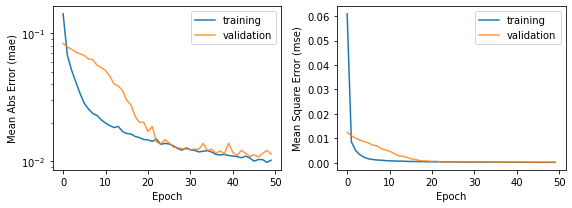

In [12]:
def plot_history(history, step=1):
    fig = plt.figure(figsize=(12, 3))
    hist = pd.DataFrame(history.history).iloc[::step]
    hist['epoch'] = history.epoch[::step]

    plt.subplot(131)
    plt.semilogy(hist['epoch'], hist['mae'], label='training')
    plt.semilogy(hist['epoch'], hist['val_mae'], label='validation', alpha=0.8)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (mae)')

    plt.subplot(132)
    plt.plot(hist['epoch'], hist['mse'], label='training')
    print(hist['mse'])
    plt.plot(hist['epoch'], hist['val_mse'], label='validation', alpha=0.8)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error (mse)')

    plt.tight_layout()


plot_history(history)
print(hist['val_mse'])

In [16]:
# Compute the overall scores of the model
scores = model.evaluate(test_data, test_labels, verbose=1)

16/16 [==============================] - 0s 24ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - mae: 0.0269 - mse: 0.0013


In [13]:
test_predictions = model.predict(test_data)

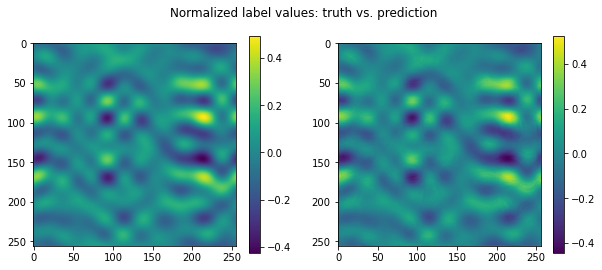

In [14]:
# compare truth and prediction for one or more test samples
for itest in range(1):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(test_labels[itest, ..., 0])
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(test_predictions[itest, ..., 0])
    plt.colorbar()
    plt.suptitle('Normalized label values: truth vs. prediction')

(-1.1, 1.1, -1.1, 1.1)

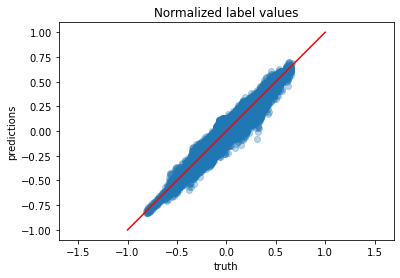

In [15]:
# do the 45-degree plot; close to the diagonal == good
plt.plot((-1, 1), (-1, 1), c='r')
plt.scatter(test_labels.ravel(), test_predictions.ravel(), alpha=0.3)
plt.xlabel('truth')
plt.ylabel('predictions')
plt.title('Normalized label values')
plt.axis('equal')

In [60]:
print(np.max(test_data))

17.84301344740594


### Save the model

In [30]:
model_filename = 'closure-2d-model-qxxy.h5'
model.save(model_filename)

In [31]:
import h5py

model_file = h5py.File(model_filename, 'r')


def print_obj(name, obj):
    info = ''
    if isinstance(obj, h5py._hl.dataset.Dataset):
        info = str(obj.shape)
    print('{:42s} {:10s} {}'.format(name, info, type(obj)))


model_file.visititems(print_obj)

model_file.close()

model_weights                                         <class 'h5py._hl.group.Group'>
model_weights/conv2d                                  <class 'h5py._hl.group.Group'>
model_weights/conv2d/conv2d                           <class 'h5py._hl.group.Group'>
model_weights/conv2d/conv2d/bias:0         (48,)      <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d/conv2d/kernel:0       (16, 16, 2, 48) <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d_1                                <class 'h5py._hl.group.Group'>
model_weights/conv2d_1/conv2d_1                       <class 'h5py._hl.group.Group'>
model_weights/conv2d_1/conv2d_1/bias:0     (48,)      <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d_1/conv2d_1/kernel:0   (16, 16, 48, 48) <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d_2                                <class 'h5py._hl.group.Group'>
model_weights/conv2d_2/conv2d_2                       <class 'h5py._hl.group.Group'>
model_weights/conv2d_2/conv2d_2/bias:0